In [1]:
import numpy as np
import os
from sklearn.model_selection import train_test_split

def load_data_from_npy_files(data_dir):
    X, y = [], []
    
    for file_name in os.listdir(data_dir):
        if file_name.endswith('.npy'):
            file_path = os.path.join(data_dir, file_name)
            data = np.load(file_path, allow_pickle=True).item()  # Load the .npy file
            
            frames = data['frames']
            label = data['label']
            
            # Append the frames and label to the lists
            X.append(frames)
            y.append(label)
    
    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return X, y

# Load training and testing data
train_data_dir = 'dataset/segments/train'
test_data_dir = 'dataset/segments/test'

X_train, y_train = load_data_from_npy_files(train_data_dir)
X_test, y_test = load_data_from_npy_files(test_data_dir)

# Split the training data into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Labels shape: {y_test.shape}")


Training data shape: (2048, 32, 64, 64, 3), Labels shape: (2048,)
Validation data shape: (513, 32, 64, 64, 3), Labels shape: (513,)
Testing data shape: (436, 32, 64, 64, 3), Labels shape: (436,)


In [2]:
# Count occurrences of values 1 and 0 in y_train, y_val, and y_test
train_zeros = np.count_nonzero(y_train == 0)
train_ones = np.count_nonzero(y_train == 1)
val_zeros = np.count_nonzero(y_val == 0)
val_ones = np.count_nonzero(y_val == 1)
test_zeros = np.count_nonzero(y_test == 0)
test_ones = np.count_nonzero(y_test == 1)

# Print counts
print(f"Training data - 0s: {train_zeros}, 1s: {train_ones}")
print(f"Validation data - 0s: {val_zeros}, 1s: {val_ones}")
print(f"Testing data - 0s: {test_zeros}, 1s: {test_ones}")

Training data - 0s: 1256, 1s: 792
Validation data - 0s: 316, 1s: 197
Testing data - 0s: 280, 1s: 156


In [7]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from utils.resnet50 import extract_features_3d_resnet, build_3d_resnet_feature_extractor

# Build the 3D ResNet feature extractor model
resnet_feature_extractor = build_3d_resnet_feature_extractor(input_shape=(32, 64, 64, 3))
resnet_feature_extractor.summary()

# Extract features using 3D ResNet for training, validation, and test data
X_train_features_resnet = extract_features_3d_resnet(X_train, resnet_feature_extractor)
X_val_features_resnet = extract_features_3d_resnet(X_val, resnet_feature_extractor)
X_test_features_resnet = extract_features_3d_resnet(X_test, resnet_feature_extractor)


Model: "3D_ResNet_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 32, 64,    │      5,248 │ input_layer[0][0] │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 64,    │        256 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 64,    │          0 │ batch_normalizat… │
│                     │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 32, 32,    │          0 │ re_lu[0][0]       │
│ (MaxPooling3D)      │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 32, 32,    │    221,312 │ max_pooling3d[0]… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 32, 32,    │    442,496 │ re_lu_1[0][0]     │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 32, 32,    │      8,320 │ max_pooling3d[0]… │
│                     │ 32, 128)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ re_lu_2[0][0],    │
│                     │ 32, 128)          │            │ conv3d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 32, 32,    │    884,992 │ add[0][0]         │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv3d_5[0][0]    │
│ (BatchNormalizatio… │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32, 256)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 32, 32,    │  1,769,728 │ re_lu_3[0][0]   

 Total params: 16,223,232 (61.89 MB)

 Trainable params: 16,219,520 (61.87 MB)

 Non-trainable params: 3,712 (14.50 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from utils.c3d import build_c3d_feature_extractor, extract_features

c3d_feature_extractor = build_c3d_feature_extractor()
c3d_feature_extractor.summary()

X_train_features_c3d = extract_features(X_train, c3d_feature_extractor)
X_val_features_c3d = extract_features(X_val, c3d_feature_extractor)
X_test_features_c3d = extract_features(X_test, c3d_feature_extractor)

Model: "C3D_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 32, 64, 64, 64) │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 32, 32, 32, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 32, 32, 32,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 32, 16, 16,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_6 (Conv3D)               │ (None, 32, 16, 16,     │       884,992 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_6 (MaxPooling3D)  │ (None, 16, 8, 8, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_7 (Conv3D)               │ (None, 16, 8, 8, 512)  │     3,539,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_7 (MaxPooling3D)  │ (None, 8, 4, 4, 512)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,651,008 (17.74 MB)

 Trainable params: 4,651,008 (17.74 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:

# Concatenate C3D and 3D ResNet features
X_train_combined = np.concatenate([X_train_features_c3d, X_train_features_resnet], axis=1)
X_val_combined = np.concatenate([X_val_features_c3d, X_val_features_resnet], axis=1)
X_test_combined = np.concatenate([X_test_features_c3d, X_test_features_resnet], axis=1)

print(X_train_combined.shape)  # Check the new shape of the combined feature vectors

X_train_features = X_train_combined
X_val_features = X_val_combined
X_test_features = X_test_combined


In [ ]:
# Step 2: Define the fully connected classifier
fc_classifier = Sequential([
Dense(512, activation='relu', input_shape=(X_train_features.shape[1],)),
Dense(256, activation='relu'),
Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
fc_classifier.compile(optimizer=Adam(learning_rate=0.001), 
loss='binary_crossentropy', 
metrics=['accuracy'])

checkpoint = ModelCheckpoint("models/c3d/c3d_resnet_model_3.keras", monitor='val_loss', save_best_only=True, verbose=1)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Step 3: Train the classifier
feature_fc_history = fc_classifier.fit(X_train_features, y_train, epochs=20, batch_size=32, validation_data=(X_val_features, y_val), callbacks=[checkpoint, early_stop])

fc_classifier.save('models/c3d/c3d_resnet_model_3.h5')

/Users/vishnu/garage/cs512-f24-sellamshanmugavel-vishnupriyan/cv_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5326 - loss: 0.9137
Epoch 1: val_loss improved from inf to 0.66419, saving model to models/c3d/c3d_model_3.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.5330 - loss: 0.9117 - val_accuracy: 0.6530 - val_loss: 0.6642
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5903 - loss: 0.6586
Epoch 2: val_loss did not improve from 0.66419
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.5907 - loss: 0.6586 - val_accuracy: 0.6160 - val_loss: 0.7288
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6073 - loss: 0.6598
Epoch 3: val_loss improved from 0.66419 to 0.58421, saving model to models/c3d/c3d_model_3.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6075 - loss: 0.6595 - val_accuracy: 0.7193 - val_loss: 0.5842
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6647 - loss: 0.5981
Epoch 4: val_loss improved from 0.58421 to 0.57742, saving model to models/

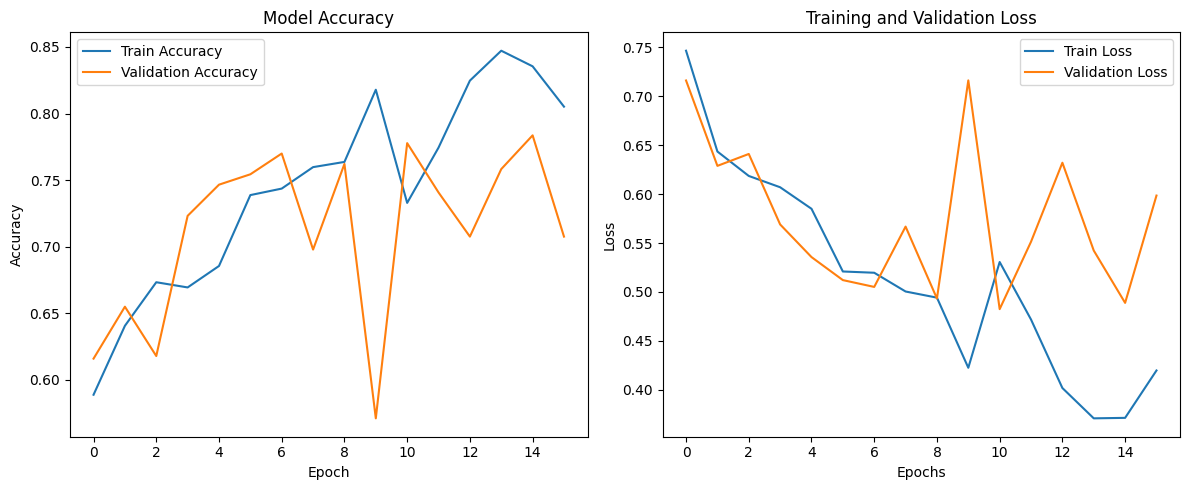

In [ ]:
from utils.plots import plot_history, evaluate_and_plot

plot_history(c3d_feature_fc_history)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
      Dataset      Loss  Accuracy  Precision    Recall  F1-Score       AUC  \
0    Training  0.429006  0.778809   0.974790  0.439394  0.605744  0.716114   
1  Validation  0.598502  0.707602   0.873016  0.279188  0.423077  0.626936   
2        Test  0.608017  0.713303   0.918919  0.217949  0.352332  0.603617   

        mAP       IoU  
0  0.935495  0.136564  
1  0.784919  0.102597  
2  0.785062  0.073645  
Best IoU: 0.1366


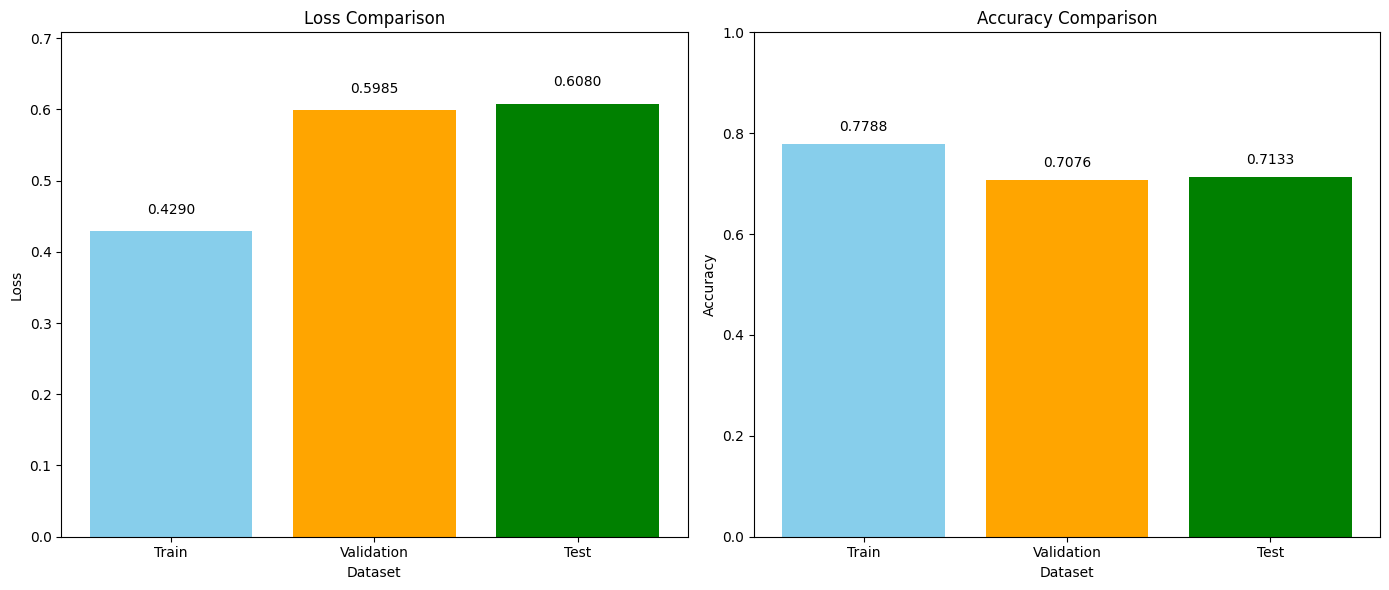

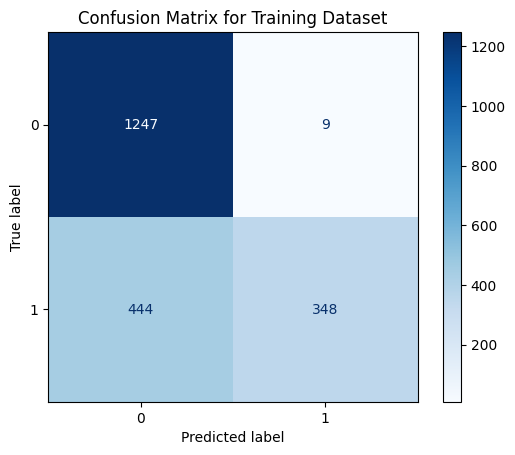

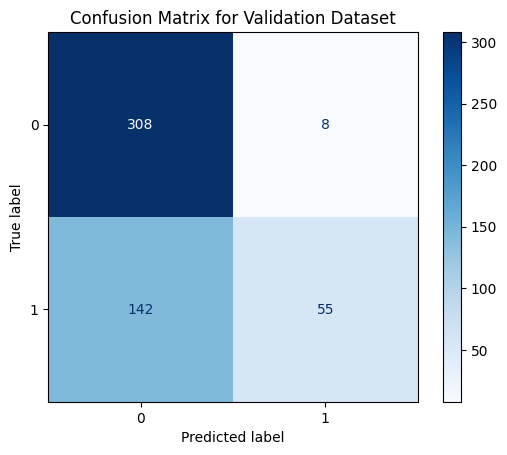

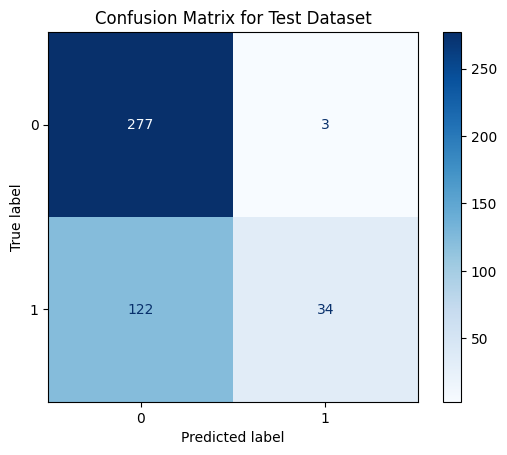

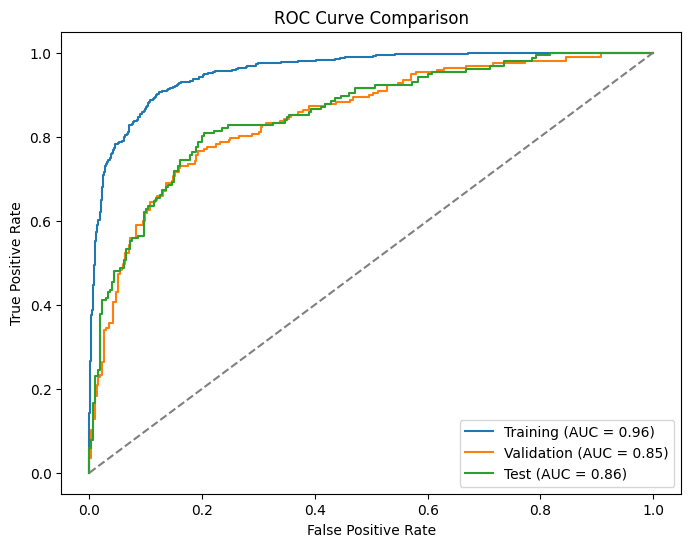

In [ ]:
evaluate_and_plot(fc_classifier, X_train_features, y_train, X_val_features, y_val, X_test_features, y_test)